In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

import scipy as sp 
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import decomposition
from sklearn import preprocessing


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



### Fonctions

#### Affichage ACP

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [3]:
data = pd.read_csv("Projet_3_Clean.csv")

In [4]:
data

,product_name,quantity,categories,allergens,additives_n,nutriscore_score,nutriscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,Vitória crackers,Other,Other,Other,1.587816,9.477385,Other,375.000000,7.000000,3.080000,70.100000,15.000000,2.992322,7.800000,1.400000
1,Cacao,130 g,Other,Other,1.587816,9.477385,Other,274.924787,14.118013,5.404259,27.193757,13.830217,2.992322,8.878969,1.245616
2,moutarde au moût de raisin,100g,Other,en:mustard,0.000000,18.000000,d,274.924787,8.200000,2.200000,29.000000,22.000000,0.000000,5.100000,4.600000
3,Sfiudwx,dgesc,Other,Other,1.587816,9.477385,Other,274.924787,14.118013,5.404259,27.193757,13.830217,2.992322,8.878969,1.245616
4,Sauce Sweety chili 0%,Other,Other,Other,1.587816,9.477385,Other,21.000000,0.000000,0.000000,4.800000,0.400000,2.992322,0.200000,2.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726909,Boules,Other,Other,Other,1.587816,9.477385,Other,372.000000,11.000000,1.300000,58.000000,54.000000,2.992322,6.300000,0.020000
726910,Minis beignets,Other,Other,Other,1.587816,15.000000,d,333.000000,20.200000,6.000000,30.900000,10.400000,2.992322,7.400000,1.100000
726911,Steak haché pur boeuf,Other,Other,Other,1.587816,-2.000000,a,131.000000,5.000000,2.300000,0.000000,0.000000,2.992322,21.500000,0.180000
726912,Thé noir BIO Darjeeling,Other,Other,Other,1.587816,9.477385,Other,274.924787,14.118013,5.404259,27.193757,13.830217,2.992322,8.878969,1.245616


### Statistiques descriptives Univariées

### Analyse Quantitative

In [5]:
data.describe().round(2)

,additives_n,nutriscore_score,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00
mean,1.59,9.48,274.92,14.12,5.40,27.19,13.83,2.99,8.88,1.25
std,1.31,5.16,161.31,15.32,7.01,24.45,17.74,2.14,8.79,3.83
min,0.00,-15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.59,9.48,165.00,2.20,0.50,4.80,1.10,2.99,3.00,0.11
50%,1.59,9.48,274.92,14.12,4.30,27.19,9.90,2.99,8.88,1.00
75%,1.59,9.48,359.00,17.00,5.40,42.00,13.83,2.99,10.00,1.25
max,30.00,40.00,900.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


#### Pour faciliter l'analyse (en terme d'intervalle), nous allons retirer la colonne energy-kcal-100g

In [6]:
data.drop('energy-kcal_100g',1,inplace=True)

In [7]:
data.describe().round(2)

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00,726914.00
mean,1.59,9.48,14.12,5.40,27.19,13.83,2.99,8.88,1.25
std,1.31,5.16,15.32,7.01,24.45,17.74,2.14,8.79,3.83
min,0.00,-15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.59,9.48,2.20,0.50,4.80,1.10,2.99,3.00,0.11
50%,1.59,9.48,14.12,4.30,27.19,9.90,2.99,8.88,1.00
75%,1.59,9.48,17.00,5.40,42.00,13.83,2.99,10.00,1.25
max,30.00,40.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


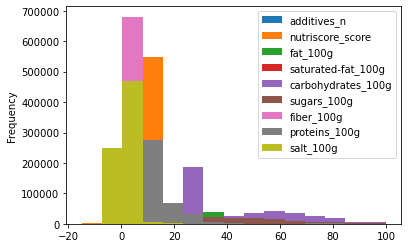

In [8]:
data.plot.hist(bins=15)

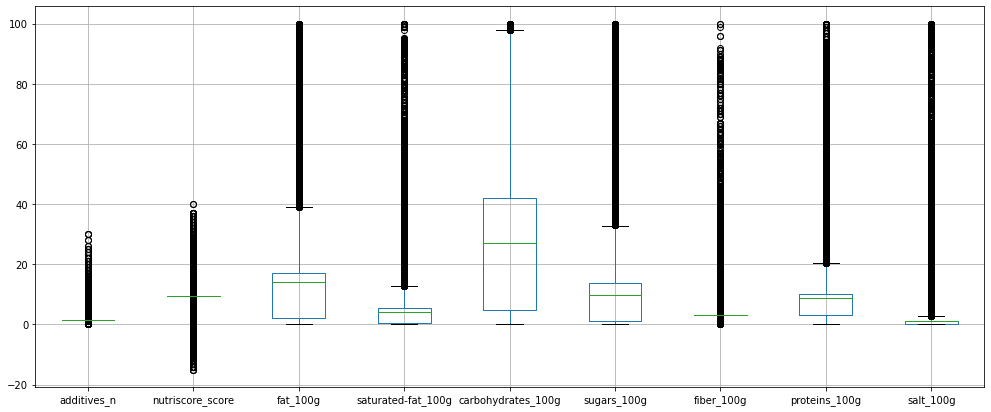

In [9]:
plt.figure(figsize=(17,7))
data.boxplot()

additives_n 



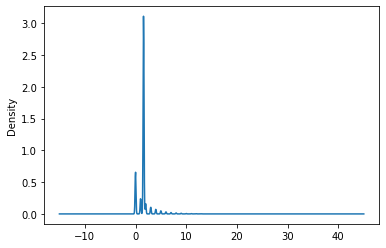

----------------------------------------
nutriscore_score 



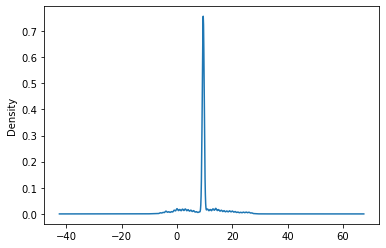

----------------------------------------
fat_100g 



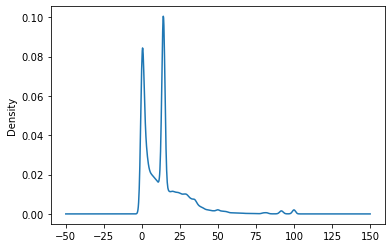

----------------------------------------
saturated-fat_100g 



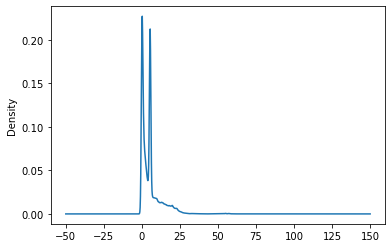

----------------------------------------
carbohydrates_100g 



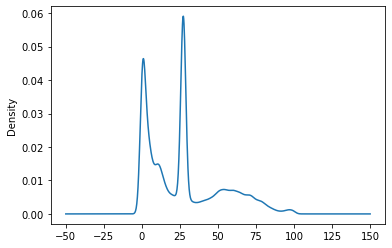

----------------------------------------
sugars_100g 



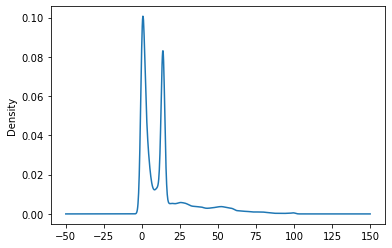

----------------------------------------
fiber_100g 



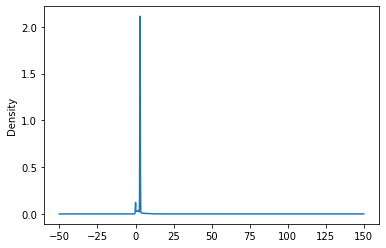

----------------------------------------
proteins_100g 



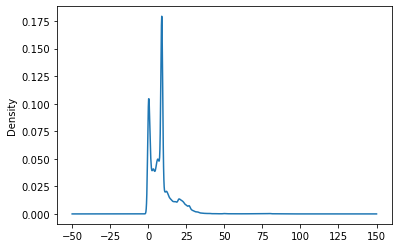

----------------------------------------
salt_100g 



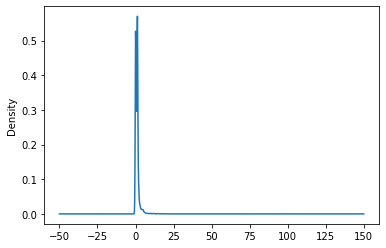

----------------------------------------


In [10]:
for col in data.describe().columns:
    print(col,"\n")
    data[col].plot(kind="kde")
    plt.show()
    print("--"*20)

### Analyse Qualitative

In [11]:
i = 0
cat_data = []

for col in data.columns:
    if data.columns[i] not in list(data.describe().columns):
        cat_data.append(data.columns[i])
    i = i +1


In [12]:
for elt in cat_data :
    print(elt,"\n")
    print(data[elt].describe())
    print("--"*20)

product_name 

count     726914
unique    481925
top        Other
freq       23466
Name: product_name, dtype: object
----------------------------------------
quantity 

count     726914
unique     21657
top        Other
freq      489226
Name: quantity, dtype: object
----------------------------------------
categories 

count     726914
unique        10
top        Other
freq      712232
Name: categories, dtype: object
----------------------------------------
allergens 

count     726914
unique      3377
top        Other
freq      647232
Name: allergens, dtype: object
----------------------------------------
nutriscore_grade 

count     726914
unique         6
top        Other
freq      475004
Name: nutriscore_grade, dtype: object
----------------------------------------


#### Les colonnes qualitatives qui vont être utiles pour l'analyse sont : 
* categories
* nutriscore_grade
 

#### Pour faciliter l'analyse (en terme de fréquence), nous allons retirer les lignes dont le nutriscore_grade est "Other"

In [13]:
data["nutriscore_grade"].value_counts()

Other    475004
d         78158
c         55494
e         50819
a         34619
b         32820
Name: nutriscore_grade, dtype: int64

In [14]:
data.drop(data[ data['nutriscore_grade'] == 'Other' ].index , inplace=True)

In [15]:
data.shape

(251910, 14)

#### Nous passons donc de 726914 lignes à 251 910 lignes 

In [16]:
col_cat = ["categories","nutriscore_grade"]

In [17]:
for elt in col_cat :
    print(elt,"\n")
    print(pd.crosstab(data[elt],"Frequence", normalize = True))
    print("--"*20)

categories 

col_0                                               Frequence
categories                                                   
Aliments et boissons à base de végétaux, Alimen...   0.000536
Aliments et boissons à base de végétaux, Alimen...   0.004327
Boissons                                             0.014724
Other                                                0.959529
Viandes, Charcuteries, Jambons, Jambons blancs       0.006911
Viandes, Volailles, Dindes, Escalopes de dinde       0.002092
Viandes, Volailles, Poulets, Aiguillettes de po...   0.001501
Viandes, Volailles, Poulets, Cuisses de poulet       0.003045
Viandes, Volailles, Poulets, Filets de poulet        0.007336
----------------------------------------
nutriscore_grade 

col_0             Frequence
nutriscore_grade           
a                  0.137426
b                  0.130285
c                  0.220293
d                  0.310262
e                  0.201735
----------------------------------------


categories 



<Figure size 720x720 with 0 Axes>

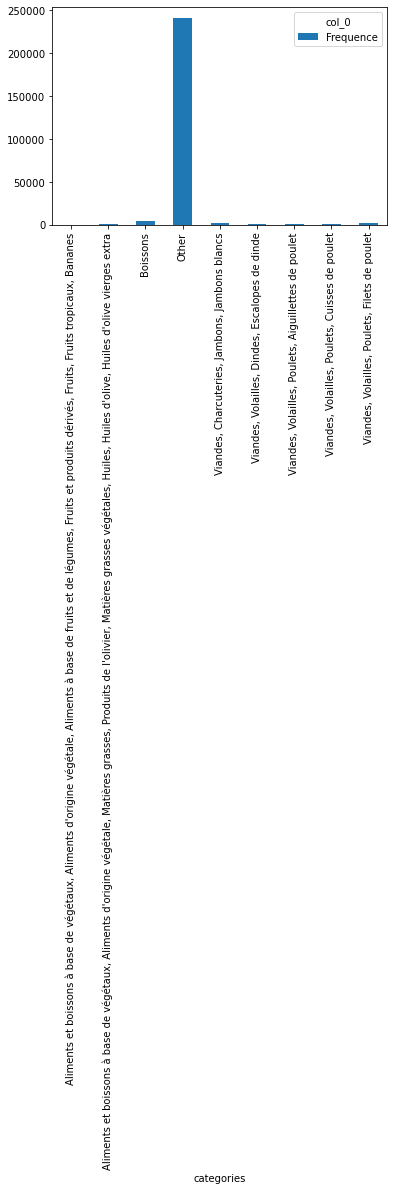

----------------------------------------
nutriscore_grade 



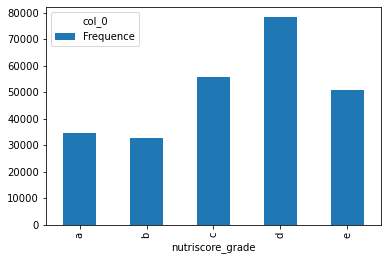

----------------------------------------


In [18]:
plt.figure(figsize=(10,10))
for elt in col_cat :
    print(elt,"\n")
    pd.crosstab(data[elt],"Frequence").plot.bar()
    plt.show()
    print("--"*20)

### Statistiques descriptives Bivariées

### Analyse Quantitative - Quantitative

#### Corrélation (lien) entre les différentes variables quantitatives

In [19]:
data.corr()

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
additives_n,1.000000,0.157011,-0.032242,-0.022291,0.105283,0.114701,-0.067280,-0.058458,0.007158
nutriscore_score,0.157011,1.000000,0.475046,0.582256,0.228928,0.387755,-0.090922,0.067324,0.170265
fat_100g,-0.032242,0.475046,1.000000,0.701295,-0.146888,-0.087178,0.045119,0.110446,0.021533
saturated-fat_100g,-0.022291,0.582256,0.701295,1.000000,-0.082607,0.013291,0.008655,0.148937,0.012341
carbohydrates_100g,0.105283,0.228928,-0.146888,-0.082607,1.000000,0.699845,0.139631,-0.237736,-0.123725
sugars_100g,0.114701,0.387755,-0.087178,0.013291,0.699845,1.000000,0.016631,-0.307527,-0.144611
fiber_100g,-0.067280,-0.090922,0.045119,0.008655,0.139631,0.016631,1.000000,0.124800,-0.005568
proteins_100g,-0.058458,0.067324,0.110446,0.148937,-0.237736,-0.307527,0.124800,1.000000,0.171197
salt_100g,0.007158,0.170265,0.021533,0.012341,-0.123725,-0.144611,-0.005568,0.171197,1.000000


#### Corrélation de Pearson entre le nutriscore_score et les autres variables quantitatives

In [20]:
for col in data.describe().columns.tolist() : 
    print("Corrélation entre",col,"et le nutriscore_score :")
    print(sp.stats.pearsonr(data[col],data["nutriscore_score"]))
    print("--"*20)

Corrélation entre additives_n et le nutriscore_score :
(0.15701103086370582, 0.0)
----------------------------------------
Corrélation entre nutriscore_score et le nutriscore_score :
(0.9999999999998636, 0.0)
----------------------------------------
Corrélation entre fat_100g et le nutriscore_score :
(0.4750455450827551, 0.0)
----------------------------------------
Corrélation entre saturated-fat_100g et le nutriscore_score :
(0.5822557561362798, 0.0)
----------------------------------------
Corrélation entre carbohydrates_100g et le nutriscore_score :
(0.22892750861753297, 0.0)
----------------------------------------
Corrélation entre sugars_100g et le nutriscore_score :
(0.38775547826032764, 0.0)
----------------------------------------
Corrélation entre fiber_100g et le nutriscore_score :
(-0.09092230104295965, 0.0)
----------------------------------------
Corrélation entre proteins_100g et le nutriscore_score :
(0.06732357276780988, 7.556866212120174e-251)
-----------------------

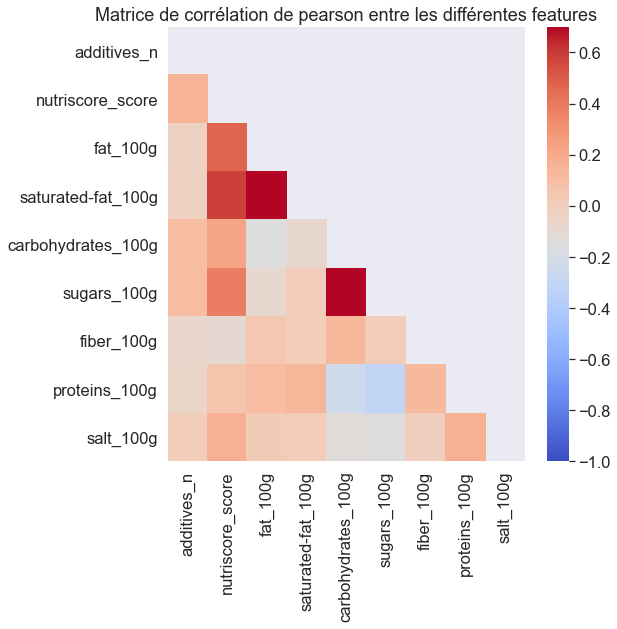

In [21]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.5)
plt.title('Matrice de corrélation de pearson entre les différentes features')

corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

#### Matrice de corrélation entre les variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026A498FC430>,
      dtype=object)

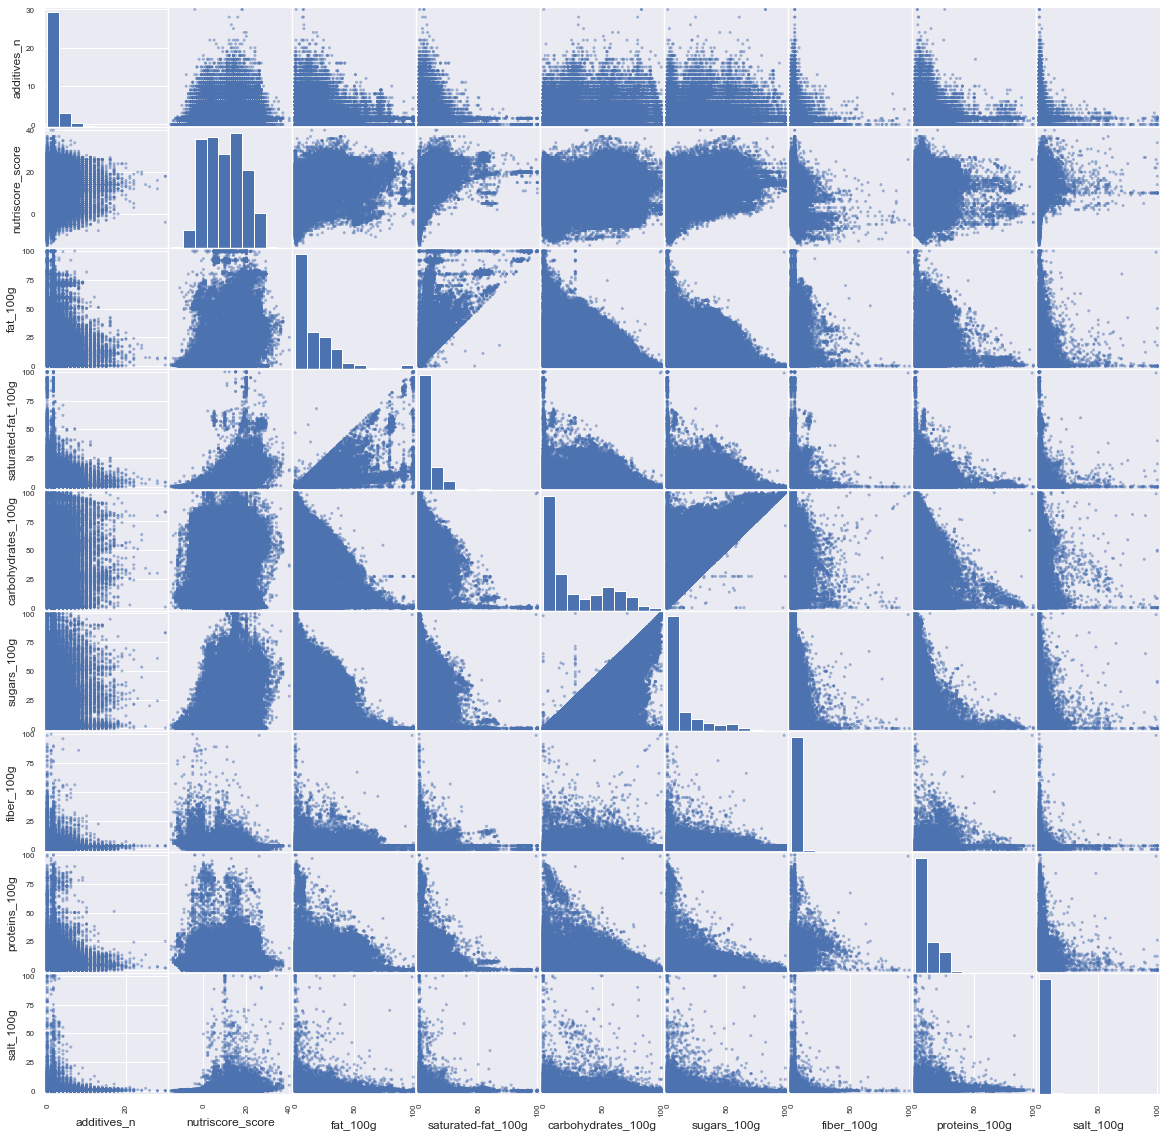

In [22]:
pd.plotting.scatter_matrix(data, figsize=(20,20))

#### Covariance

In [23]:
data.cov()

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
additives_n,3.374111,2.529078,-1.113299,-0.347388,5.131590,3.903861,-0.327158,-0.959573,0.032002
nutriscore_score,2.529078,76.896168,78.305634,43.317639,53.267495,63.002518,-2.110657,5.275583,3.633939
fat_100g,-1.113299,78.305634,353.354659,111.841920,-73.266265,-30.363946,2.245227,18.552686,0.985177
saturated-fat_100g,-0.347388,43.317639,111.841920,71.977586,-18.596327,2.089340,0.194391,11.291536,0.254832
carbohydrates_100g,5.131590,53.267495,-73.266265,-18.596327,704.083052,344.081577,9.808210,-56.371303,-7.990381
sugars_100g,3.903861,63.002518,-30.363946,2.089340,344.081577,343.316937,0.815769,-50.919199,-6.521524
fiber_100g,-0.327158,-2.110657,2.245227,0.194391,9.808210,0.815769,7.007929,2.952299,-0.035872
proteins_100g,-0.959573,5.275583,18.552686,11.291536,-56.371303,-50.919199,2.952299,79.854955,3.723455
salt_100g,0.032002,3.633939,0.985177,0.254832,-7.990381,-6.521524,-0.035872,3.723455,5.923782


#### Covariance permet de voir l'évolution d'une variable par rapport à l'autre. Si les variables ont tendance à afficher un comportement semblable, la covariance est positive. Dans le cas contraire, la covariance est négative lorsque les valeurs supérieures d'une variable correspondent principalement aux valeurs les plus petites de l'autre.

### Analyse Qualitative - Qualitative

In [24]:
pd.crosstab(data["categories"], data["nutriscore_grade"], margins=True)

nutriscore_grade,a,b,c,d,e,All
categories,,,,,,
"Aliments et boissons à base de végétaux, Aliments d'origine végétale, Aliments à base de fruits et de légumes, Fruits et produits dérivés, Fruits, Fruits tropicaux, Bananes",124,5,6,0,0,135
"Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra",0,0,1090,0,0,1090
Boissons,0,773,489,543,1904,3709
Other,33072,30962,51956,76820,48905,241715
"Viandes, Charcuteries, Jambons, Jambons blancs",3,58,1046,633,1,1741
"Viandes, Volailles, Dindes, Escalopes de dinde",361,141,16,9,0,527
"Viandes, Volailles, Poulets, Aiguillettes de poulet",250,99,24,4,1,378
"Viandes, Volailles, Poulets, Cuisses de poulet",42,284,333,106,2,767
"Viandes, Volailles, Poulets, Filets de poulet",767,498,534,43,6,1848


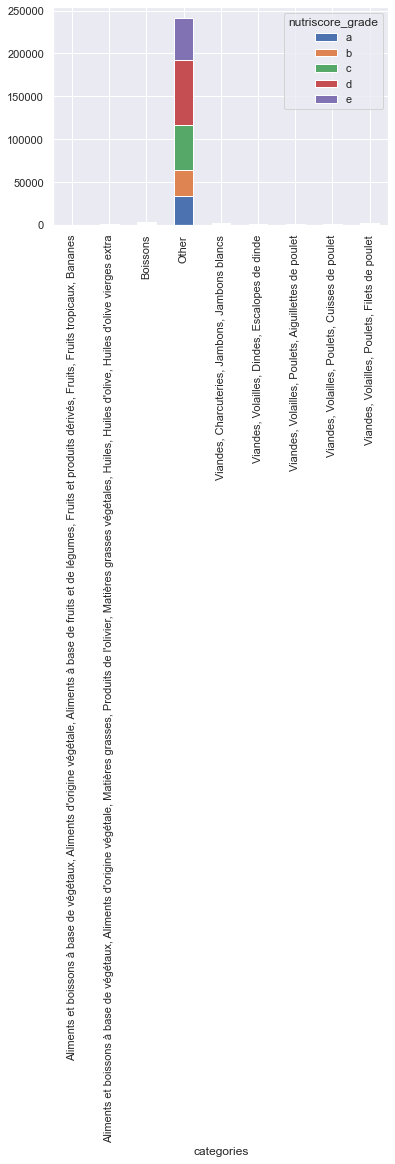

In [25]:
pd.crosstab(data["categories"], data["nutriscore_grade"]).plot.bar(stacked=True)

### Analyse Qualitative - Quantitative

In [26]:
data.groupby("nutriscore_grade").mean()

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
nutriscore_grade,,,,,,,,,
a,0.988350,-3.238742,3.853527,0.708289,22.745626,3.770925,3.912909,9.132279,0.302941
b,1.475001,0.850792,5.290622,1.196649,16.383160,4.479264,2.665144,7.803078,0.541344
c,1.645763,5.531913,13.686557,3.042525,21.754664,10.727055,2.942147,7.272572,0.937324
d,1.890354,13.842358,18.508913,7.211036,27.236622,15.084207,2.776720,10.719941,1.454928
e,1.891824,21.306362,27.087857,13.511060,32.516588,22.049793,2.656696,8.061932,1.257635


### Analyse Multivariée

### Analyse en composante principale

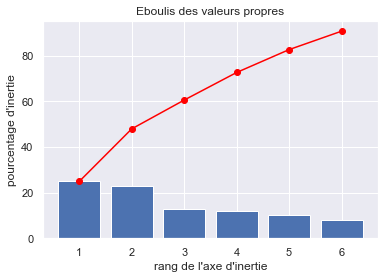

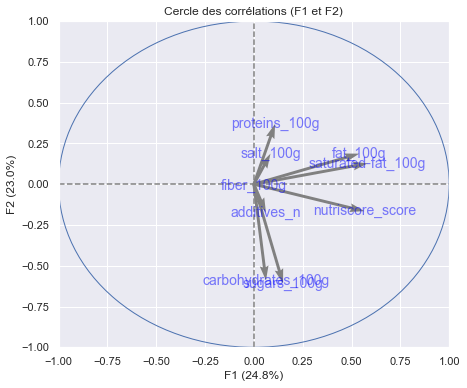

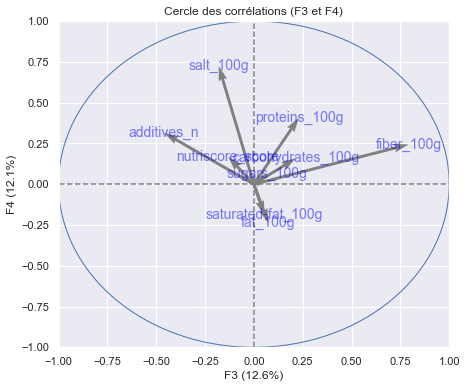

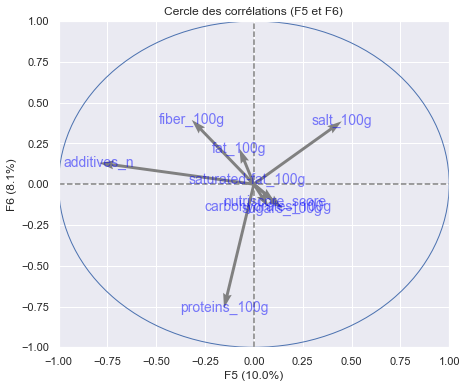

In [27]:
# choix du nombre de composantes à calculer
n_comp = 6

# préparation des données pour l'ACP
data_pca = data[data.describe().columns]
X = data_pca.values
names = data_pca.index # ou data.index pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))


### ANOVA

#### Test de normalité (nécessaire pour ANOVA)

In [28]:
for col in data.describe().columns:
    print(col,"\n")
    print(sp.stats.normaltest(data[col],axis=0))
    print("--"*20)

additives_n 

NormaltestResult(statistic=159680.41560072085, pvalue=0.0)
----------------------------------------
nutriscore_score 

NormaltestResult(statistic=42703.86884938158, pvalue=0.0)
----------------------------------------
fat_100g 

NormaltestResult(statistic=106066.12755544868, pvalue=0.0)
----------------------------------------
saturated-fat_100g 

NormaltestResult(statistic=177832.83630206855, pvalue=0.0)
----------------------------------------
carbohydrates_100g 

NormaltestResult(statistic=33958.42493674798, pvalue=0.0)
----------------------------------------
sugars_100g 

NormaltestResult(statistic=87040.64729874897, pvalue=0.0)
----------------------------------------
fiber_100g 

NormaltestResult(statistic=383151.99754776544, pvalue=0.0)
----------------------------------------
proteins_100g 

NormaltestResult(statistic=110454.46295402567, pvalue=0.0)
----------------------------------------
salt_100g 

NormaltestResult(statistic=528112.8310215865, pvalue=0.0)
----

In [29]:
for col in data.describe().columns:
    print(col,"\n")
    print(sp.stats.kstest(data[col],'norm'))
    print("--"*20)

additives_n 

KstestResult(statistic=0.5794456551233641, pvalue=0.0)
----------------------------------------
nutriscore_score 

KstestResult(statistic=0.7497479824577594, pvalue=0.0)
----------------------------------------
fat_100g 

KstestResult(statistic=0.6940614277358349, pvalue=0.0)
----------------------------------------
saturated-fat_100g 

KstestResult(statistic=0.5163343748319378, pvalue=0.0)
----------------------------------------
carbohydrates_100g 

KstestResult(statistic=0.7448970436304004, pvalue=0.0)
----------------------------------------
sugars_100g 

KstestResult(statistic=0.5773363199710748, pvalue=0.0)
----------------------------------------
fiber_100g 

KstestResult(statistic=0.7760827845696248, pvalue=0.0)
----------------------------------------
proteins_100g 

KstestResult(statistic=0.7252670170336, pvalue=0.0)
----------------------------------------
salt_100g 

KstestResult(statistic=0.5, pvalue=0.0)
----------------------------------------


#### Pvalue = 0 (avec deux tests) : Cela signifie que l'hypothèse de normalité n'est pas vérifiée
#### On peut donc utiliser l'ANOVA (Pas de normalité)

#### One way Anova

In [30]:
data_a = data["nutriscore_score"][data["nutriscore_grade"] == "a"]
data_b = data["nutriscore_score"][data["nutriscore_grade"] == "b"]
data_c = data["nutriscore_score"][data["nutriscore_grade"] == "c"]
data_d = data["nutriscore_score"][data["nutriscore_grade"] == "d"]
data_e = data["nutriscore_score"][data["nutriscore_grade"] == "e"]

In [31]:
data.describe().columns.tolist()

['additives_n',
 'nutriscore_score',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g']

In [32]:
for col in data.describe().columns.tolist(): 
    print("Test Anova entre",col,"et le nutriscore_grade :")
    data_a = data[col][data["nutriscore_grade"] == "a"]
    data_b = data[col][data["nutriscore_grade"] == "b"]
    data_c = data[col][data["nutriscore_grade"] == "c"]
    data_d = data[col][data["nutriscore_grade"] == "d"]
    data_e = data[col][data["nutriscore_grade"] == "e"]
    F, p = stats.f_oneway(data_a,data_b,data_c,data_d,data_e)
    print("F=",F,"P_value =",p)
    print("--"*20)

Test Anova entre additives_n et le nutriscore_grade :
F= 1800.8392050959242 P_value = 0.0
----------------------------------------
Test Anova entre nutriscore_score et le nutriscore_grade :
F= 590528.1885643019 P_value = 0.0
----------------------------------------
Test Anova entre fat_100g et le nutriscore_grade :
F= 13621.887365609475 P_value = 0.0
----------------------------------------
Test Anova entre saturated-fat_100g et le nutriscore_grade :
F= 25257.90604204948 P_value = 0.0
----------------------------------------
Test Anova entre carbohydrates_100g et le nutriscore_grade :
F= 2379.858055246264 P_value = 0.0
----------------------------------------
Test Anova entre sugars_100g et le nutriscore_grade :
F= 8306.591729123786 P_value = 0.0
----------------------------------------
Test Anova entre fiber_100g et le nutriscore_grade :
F= 1511.9077790502797 P_value = 0.0
----------------------------------------
Test Anova entre proteins_100g et le nutriscore_grade :
F= 1544.44813672

#### Anova montre que l'hypothese de normalité est infrimée selon laquelle les distributions par nutrigrade provienennt du même échantillon. Implique donc un lien entre le nutri_score et le nutri_grade.

### Test du jeu de données par un modèle de Regression Linéaire

#### Préparation des données

In [33]:
data_reg = data.select_dtypes(np.number)

In [34]:
data_reg

,additives_n,nutriscore_score,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
2,0.000000,18.0,8.2,2.2,29.0,22.0,0.000000,5.1,4.60
12,1.587816,1.0,0.3,0.1,5.3,3.9,2.992322,0.9,0.42
20,1.587816,14.0,22.0,15.5,27.3,21.9,4.400000,4.6,0.10
30,1.587816,-2.0,0.0,0.0,36.0,27.0,3.600000,0.6,0.00
34,1.587816,1.0,12.7,1.0,3.9,1.0,2.992322,1.9,0.27
...,...,...,...,...,...,...,...,...,...
726903,1.587816,7.0,6.1,4.3,21.0,14.0,2.992322,2.9,0.08
726905,1.587816,17.0,27.0,17.0,19.0,18.0,2.992322,6.0,0.19
726907,1.587816,0.0,0.5,0.0,80.0,0.0,2.992322,7.0,0.00
726910,1.587816,15.0,20.2,6.0,30.9,10.4,2.992322,7.4,1.10


In [39]:
X = data_reg
y = X['nutriscore_score']
X = X.drop(['nutriscore_score'],axis=1)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#### Régression linéaire multiple

In [40]:
lr = LinearRegression().fit(X_train, y_train)
print('R² sur jeu d\'entraînement : ', lr.score(X_train,y_train))
print('R² sur jeu de test', lr.score(X_test,y_test))
print('Poids de chaque variable dans la régression', lr.coef_)
print('ordonnée à l\'origine', lr.intercept_)

R² sur jeu d'entraînement :  0.5920213902894538
R² sur jeu de test 0.58872977010465
Poids de chaque variable dans la régression [ 1.01957985  2.00949229  3.56106173  0.60954728  3.57363166 -1.09149486
  0.96103605  1.84053272]
ordonnée à l'origine 9.485856746636026


#### Le coefficient R² est très faible => Le modèle ne décrit pas de manière pertinente notre jeu de données

In [46]:
resultat = pd.DataFrame({'nutriscore_reel' : y_test, 'prediction' : lr.predict(X_test)}).reset_index()

In [48]:
resultat.head(5)

,index,nutriscore_reel,prediction
0,174602,23.0,21.917025
1,378741,-2.0,3.477812
2,605173,0.0,0.571634
3,270876,1.0,5.172755
4,629238,9.0,7.423784


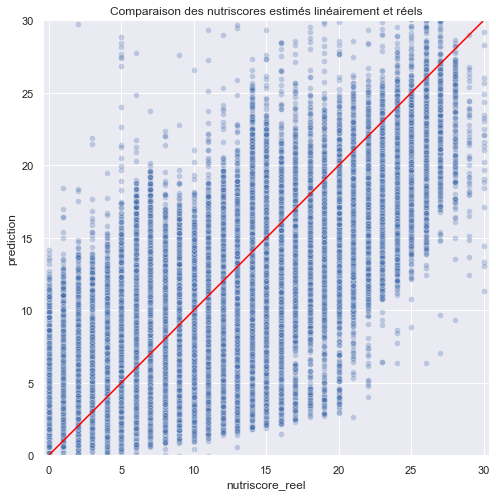

In [47]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.title('Comparaison des nutriscores estimés linéairement et réels')
sns.scatterplot(x = resultat['nutriscore_reel'], y = resultat['prediction'], alpha=0.3)
sns.lineplot([0 , 30], [0, 30], color='red')
ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.show()